## CLUSTERING ANALYSIS 

#### Understanding and Implementing K-Means, Hierarchical, and DBSCAN Algorithms

#### Data Preprocessing:¶

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

##### 1. Preprocess the dataset to handle missing values, remove outliers, and scale the features if necessary.

##### 2.	Perform exploratory data analysis (EDA) to gain insights into the distribution of data and identify potential clusters.

##### 3.	Use multiple visualizations to understand the hidden patterns in the dataset


In [2]:
#Read the given data set

df = pd.read_excel("EastWestAirlines.xlsx",sheet_name=1)
df.head()


,ID#,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
0,1,28143,0,1,1,1,174,1,0,0,7000,0
1,2,19244,0,1,1,1,215,2,0,0,6968,0
2,3,41354,0,1,1,1,4123,4,0,0,7034,0
3,4,14776,0,1,1,1,500,1,0,0,6952,0
4,5,97752,0,4,1,1,43300,26,2077,4,6935,1


In [3]:
df.shape

(3999, 12)

The dataset contains 3999 rows and 12 columns.

In [4]:
df.columns

Index(['ID#', 'Balance', 'Qual_miles', 'cc1_miles', 'cc2_miles', 'cc3_miles',
       'Bonus_miles', 'Bonus_trans', 'Flight_miles_12mo', 'Flight_trans_12',
       'Days_since_enroll', 'Award?'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999 entries, 0 to 3998
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   ID#                3999 non-null   int64
 1   Balance            3999 non-null   int64
 2   Qual_miles         3999 non-null   int64
 3   cc1_miles          3999 non-null   int64
 4   cc2_miles          3999 non-null   int64
 5   cc3_miles          3999 non-null   int64
 6   Bonus_miles        3999 non-null   int64
 7   Bonus_trans        3999 non-null   int64
 8   Flight_miles_12mo  3999 non-null   int64
 9   Flight_trans_12    3999 non-null   int64
 10  Days_since_enroll  3999 non-null   int64
 11  Award?             3999 non-null   int64
dtypes: int64(12)
memory usage: 375.0 KB


In [6]:
df.isnull().sum()

ID#                  0
Balance              0
Qual_miles           0
cc1_miles            0
cc2_miles            0
cc3_miles            0
Bonus_miles          0
Bonus_trans          0
Flight_miles_12mo    0
Flight_trans_12      0
Days_since_enroll    0
Award?               0
dtype: int64

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID#,3999.0,2014.819455,1160.764358,1.0,1010.5,2016.0,3020.5,4021.0
Balance,3999.0,73601.327582,100775.664958,0.0,18527.5,43097.0,92404.0,1704838.0
Qual_miles,3999.0,144.114529,773.663804,0.0,0.0,0.0,0.0,11148.0
cc1_miles,3999.0,2.059515,1.376919,1.0,1.0,1.0,3.0,5.0
cc2_miles,3999.0,1.014504,0.147650,1.0,1.0,1.0,1.0,3.0
cc3_miles,3999.0,1.012253,0.195241,1.0,1.0,1.0,1.0,5.0
Bonus_miles,3999.0,17144.846212,24150.967826,0.0,1250.0,7171.0,23800.5,263685.0
Bonus_trans,3999.0,11.601900,9.603810,0.0,3.0,12.0,17.0,86.0
Flight_miles_12mo,3999.0,460.055764,1400.209171,0.0,0.0,0.0,311.0,30817.0
Flight_trans_12,3999.0,1.373593,3.793172,0.0,0.0,0.0,1.0,53.0


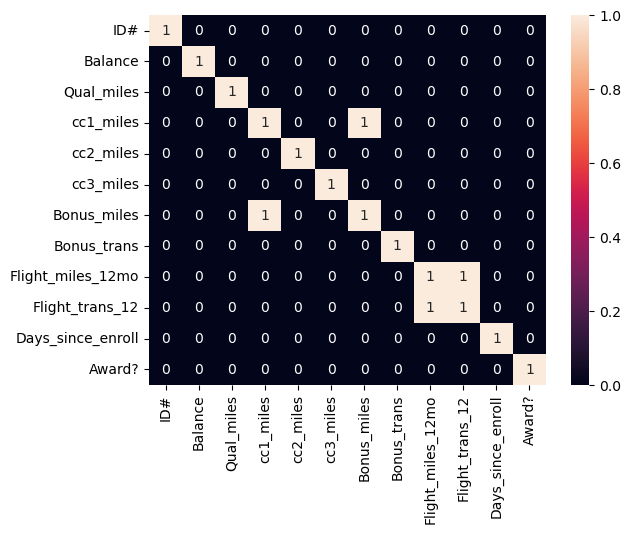

In [8]:
#Let's check for correlation between the columns.
sns.heatmap(df.corr()>0.8, annot=True, cbar=True)
plt.show()

* We are assuming that the columns ["cc1_miles", "Bonus_miles"] and ["Flight_miles_12mo", "Flight_trans_12"] are highly correlated so we'll be removing them.
* We will also be removing ID# column because it doesn't provide any meaningful insights for our model

In [9]:
df = df.drop(columns=["ID#","Bonus_miles","Flight_trans_12"], axis=1)

In [10]:
df.columns  

Index(['Balance', 'Qual_miles', 'cc1_miles', 'cc2_miles', 'cc3_miles',
       'Bonus_trans', 'Flight_miles_12mo', 'Days_since_enroll', 'Award?'],
      dtype='object')

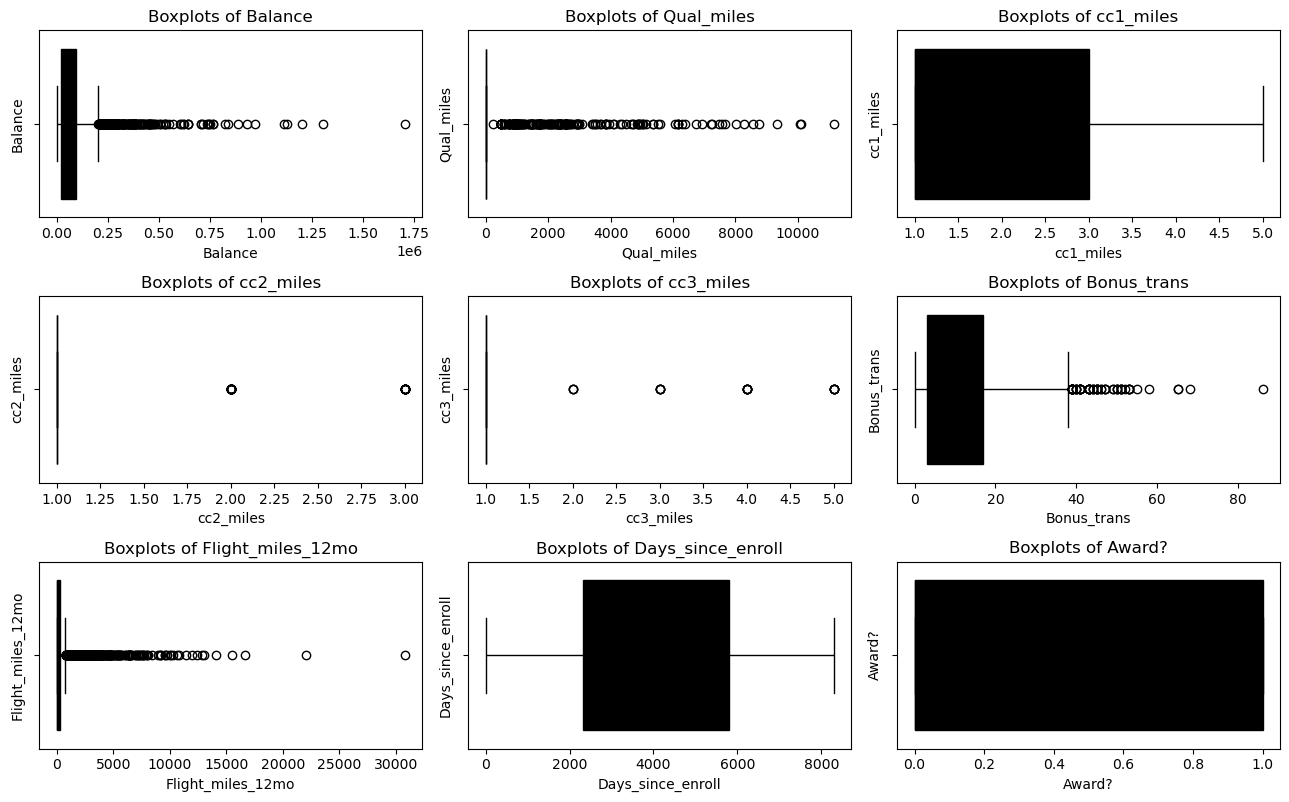

In [11]:
# Ploting the box plots to detect the outliers
plt.figure(figsize=(13,13))
index=1
for col in df.columns:
    plt.subplot(5,3,index)
    sns.boxplot(x=df[col],color='black')
    plt.title(f'Boxplots of {col}')
    index+=1
    plt.ylabel(col)
plt.tight_layout()
plt.show()

In [12]:
def remove_outliers(df, column):                                             #function to remove outliers
    Q1 = df[column].quantile(0.25)                                           #defining Q1 
    Q3 = df[column].quantile(0.75)                                           #defining Q3
    IQR = Q3 - Q1                                                            #defining IQR
    lower_bound = Q1 - 1.5 * IQR                                             #calculating lower bound
    upper_bound = Q3 + 1.5 * IQR                                             #calculating upper bound
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]     #returning all the rows with greater than lower bound and lesser than upper bound

print("Dataset size before removing outliers: ", df.shape)
for col in df.columns:
    df = remove_outliers(df, col)                                            # calling the function
print("Dataset size after removing outliers: ", df.shape)

Dataset size before removing outliers:  (3999, 9)
Dataset size after removing outliers:  (2763, 9)


After removing the outliers, the number of rows has been reduced in the dataset.

As we can we only having numerical columns in our dataset ,no need of applyinh any encoding techniques.

In [13]:
#Feature Scaling : Scaling down the features using Standard Scaler.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
df_scaled

array([[-0.44255777,  0.        , -0.72810632, ..., -0.29097683,
         1.47734549, -0.63333689],
       [-0.64649132,  0.        , -0.72810632, ..., -0.29097683,
         1.46176095, -0.63333689],
       [-0.13980847,  0.        , -0.72810632, ..., -0.29097683,
         1.49390406, -0.63333689],
       ...,
       [ 0.38798043,  0.        , -0.72810632, ..., -0.29097683,
        -1.25238406,  1.5789385 ],
       [ 0.59908682,  0.        ,  0.84727173, ..., -0.29097683,
        -1.24897494,  1.5789385 ],
       [-1.01837957,  0.        , -0.72810632, ..., -0.29097683,
        -1.25092301, -0.63333689]])

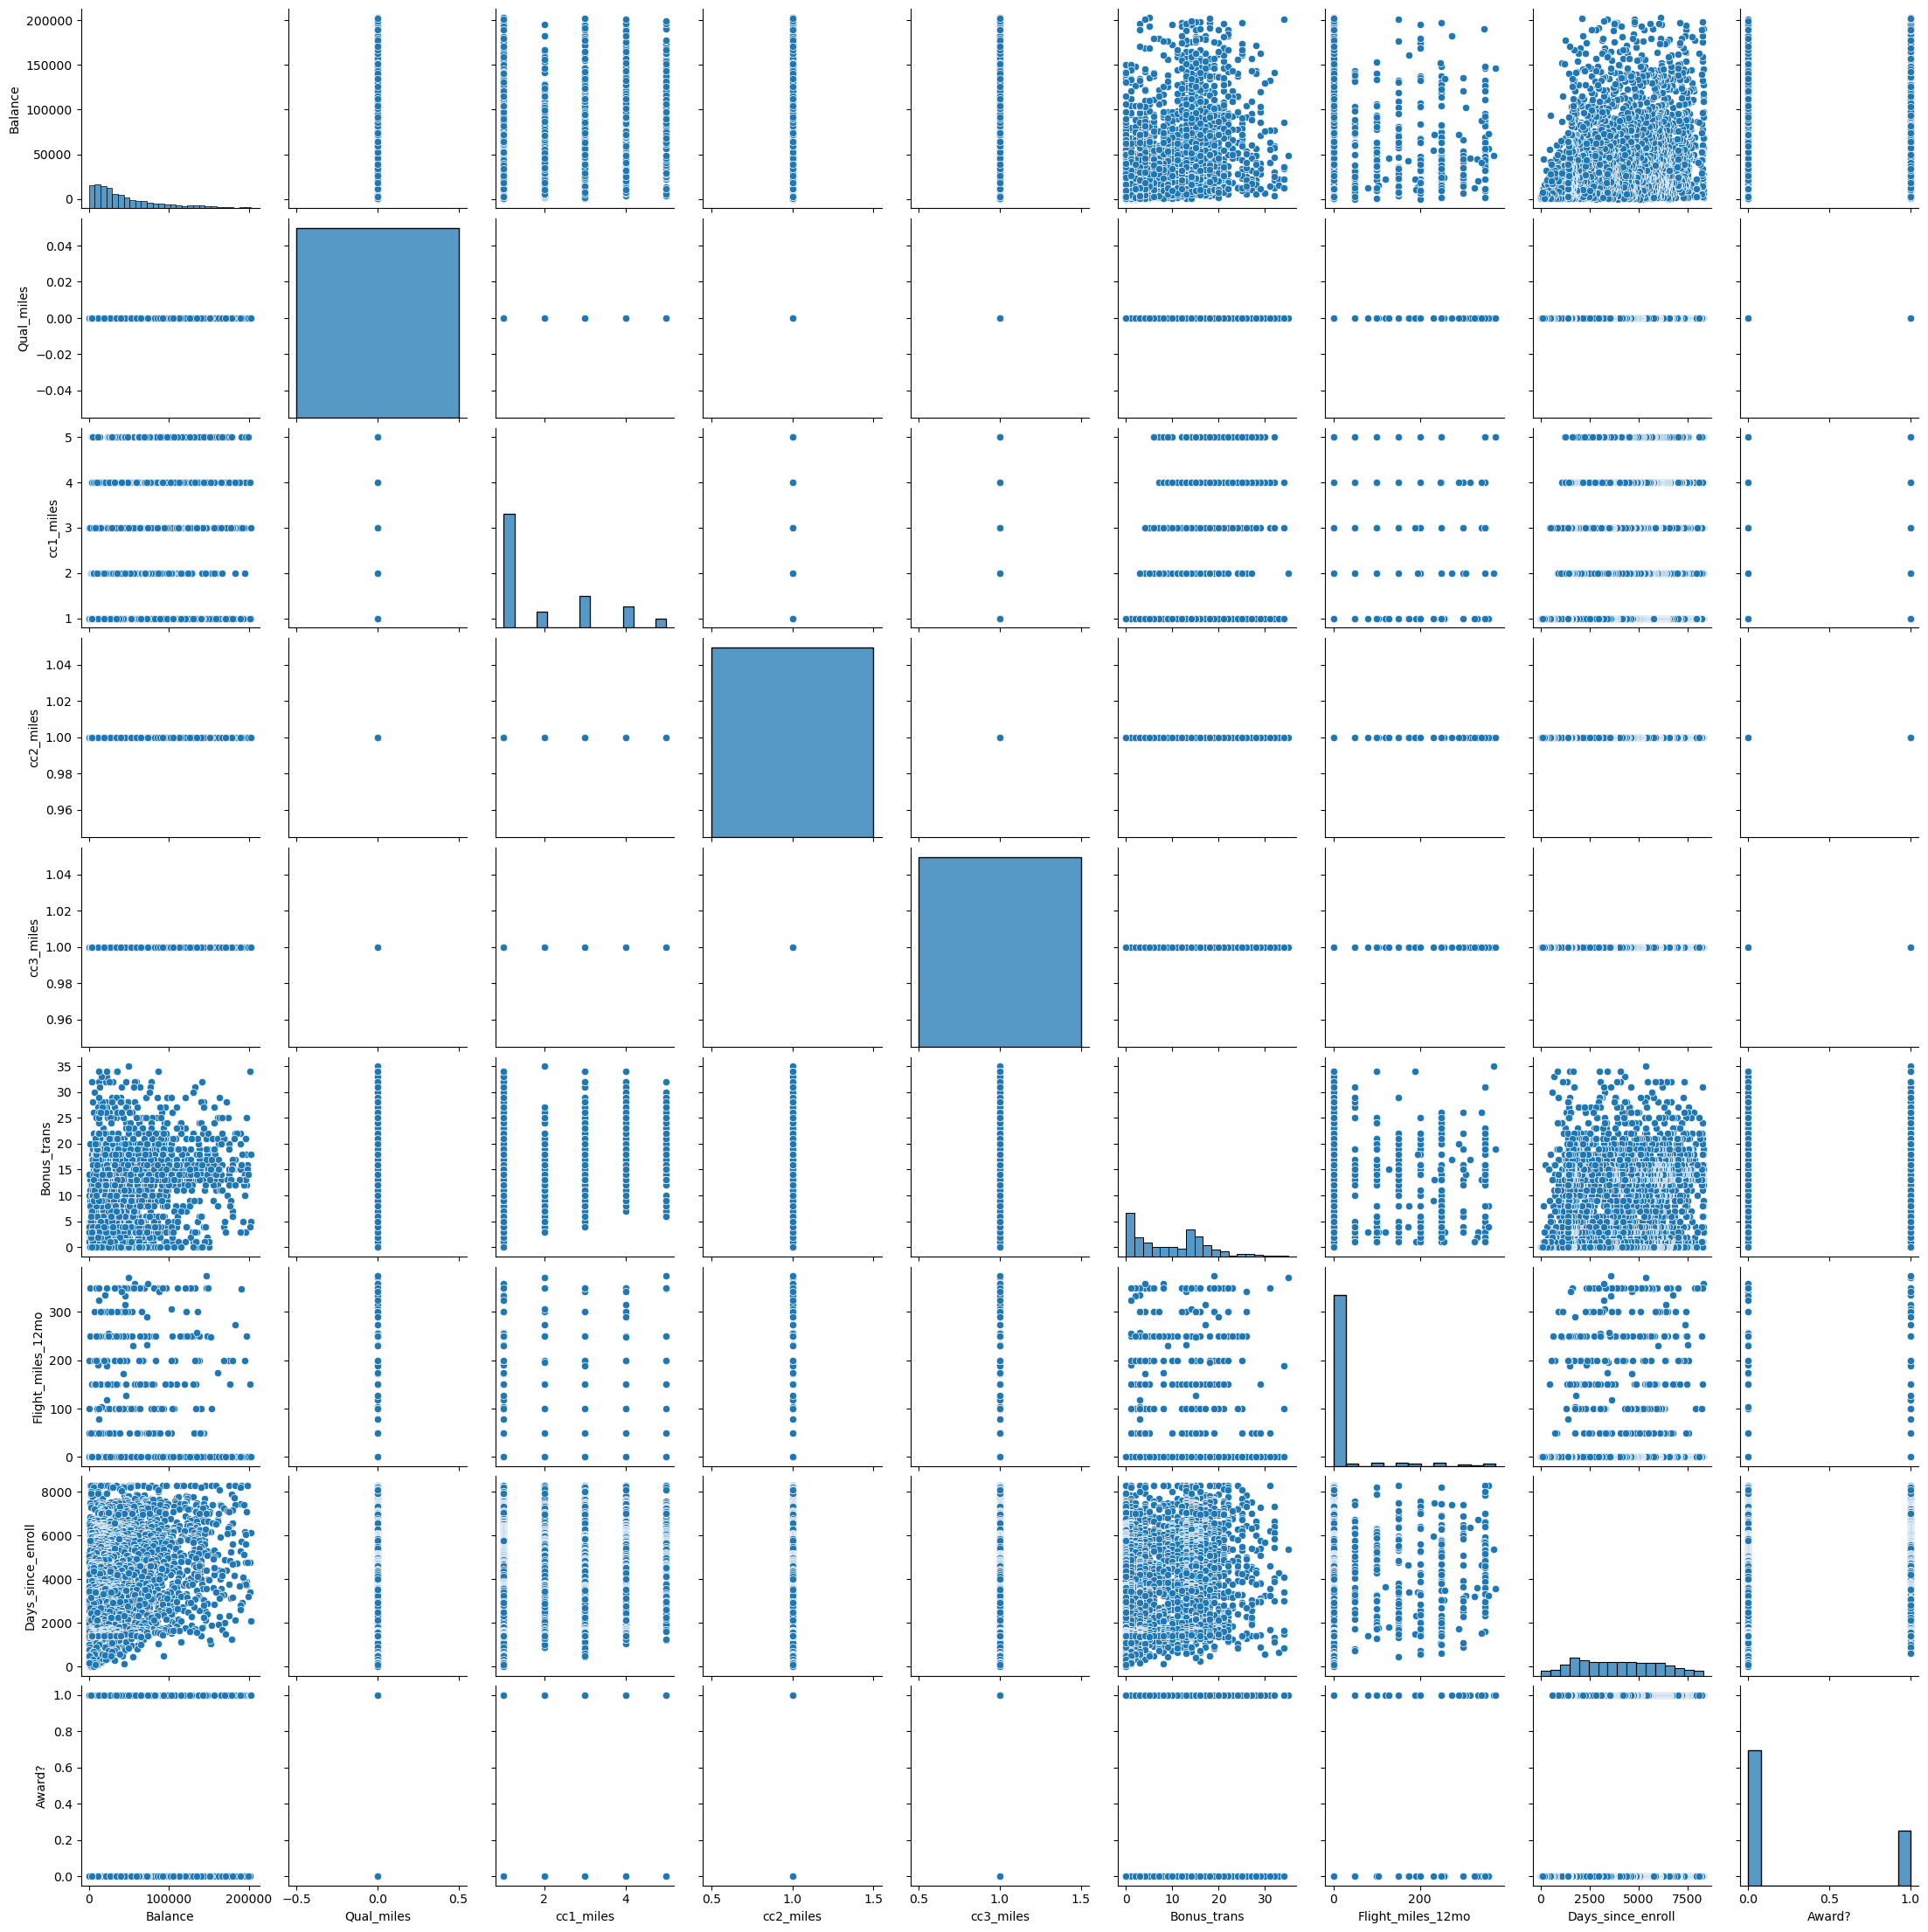

In [14]:
# Pair plots against all the columns
sns.pairplot(df)
plt.show()

Observing all the pairplots we can't be sure of any probable clusters but we do see some kind of linear relationship between many columns.

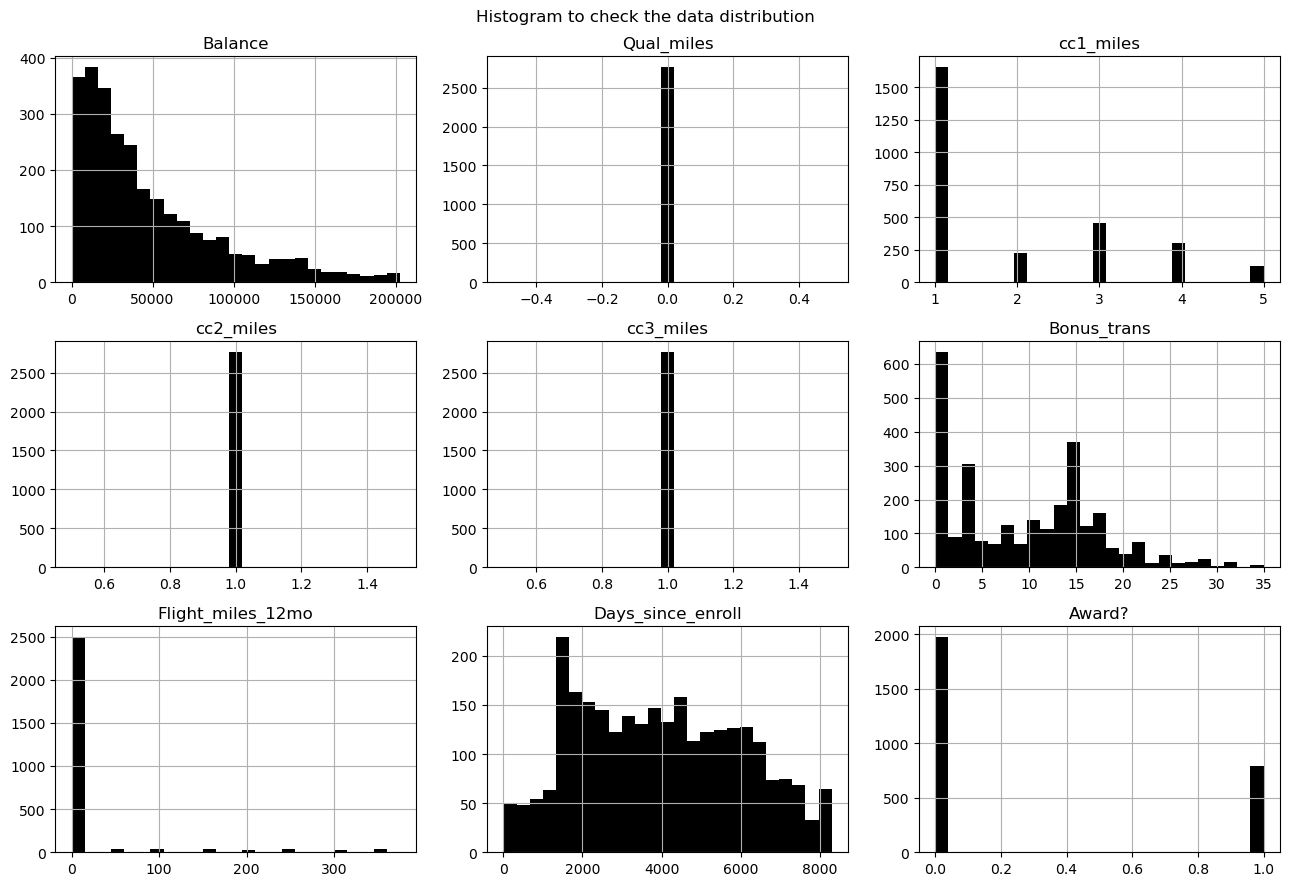

In [15]:
df.hist(figsize=(13,9),bins=25,color='black')
plt.suptitle("Histogram to check the data distribution")
plt.tight_layout()
plt.show()

In [16]:
df.columns

Index(['Balance', 'Qual_miles', 'cc1_miles', 'cc2_miles', 'cc3_miles',
       'Bonus_trans', 'Flight_miles_12mo', 'Days_since_enroll', 'Award?'],
      dtype='object')

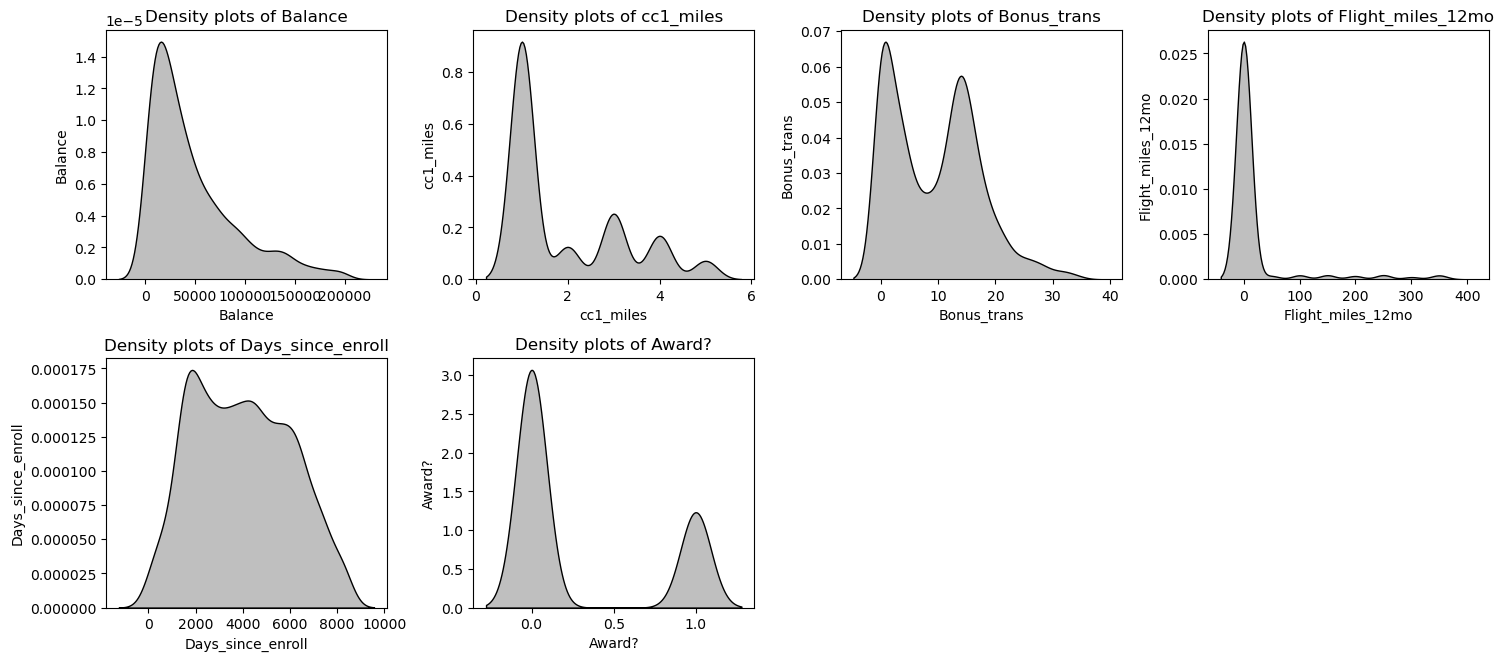

In [17]:
import warnings
warnings.filterwarnings("ignore")

# Ploting the hist plots to see the data distribution
plt.figure(figsize=(15,13))
index=1
for col in  ['Balance', 'cc1_miles','Bonus_trans', 'Flight_miles_12mo', 'Days_since_enroll', 'Award?']:
    plt.subplot(4,4,index)
    sns.kdeplot(x=df[col],color='black',fill=True)
    plt.title(f'Density plots of {col}')
    index+=1
    plt.ylabel(col)
plt.tight_layout()
plt.show()

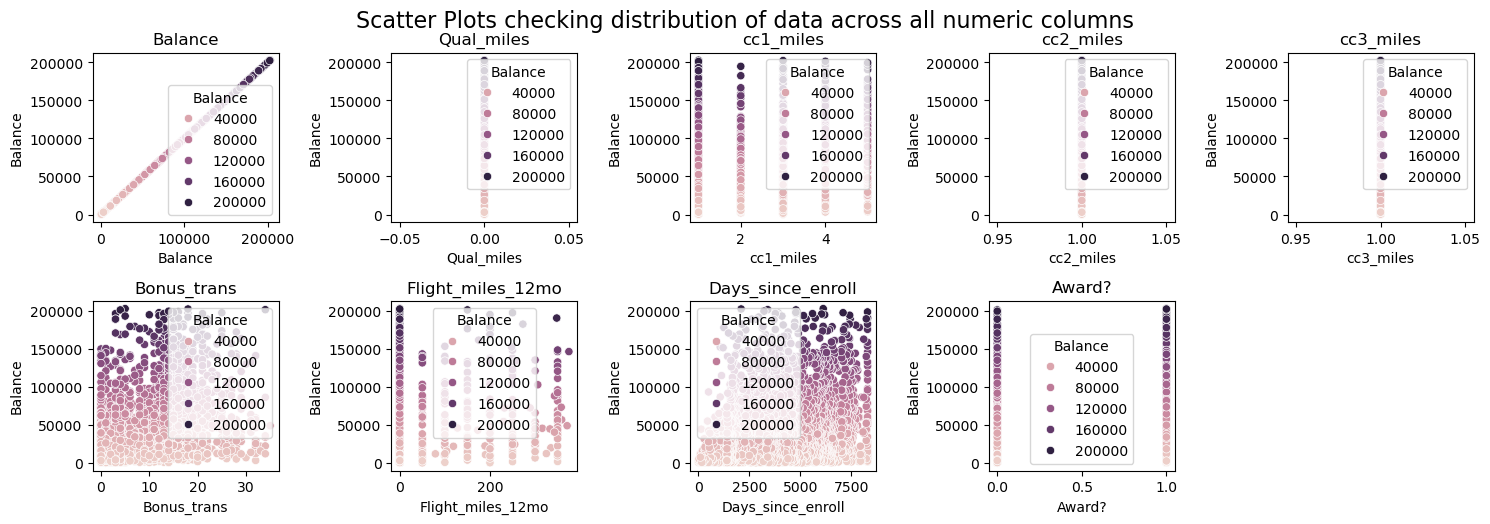

In [18]:
# Let's create boxplot and check if there is anu outlier

plt.figure(figsize=(15,15))        #setting up figure size
index = 1                          #set index to 1
for col in df.columns:         #looping through all the columns one by one except the first column
    plt.subplot(6, 5, index)       #creating subplot
    sns.scatterplot(x=df[col],y=df['Balance'],hue=df['Balance'])        
    index += 1                     #increse the index for subplot
    plt.title(f'{col}')            #setting up title
plt.suptitle("Scatter Plots checking distribution of data across all numeric columns", fontsize=16, color='black')
plt.tight_layout()                 #used for avoiding overlapping 
plt.show() 

* Most of the columns show linear or sparse realtionship with no clear distribution of data.
* Balance vs Days_since_enroll shows potential clusters since the data is lying densily towards X axis.
* Similarly Balance vs Bonus_trans also has dense distribution of data towards X axis from 5 to 20.

#### Implementing Clustering Algorithms:

##### Implement the K-Means, hierarchical, and DBSCAN algorithms using a programming language such as Python with libraries like scikit-learn or MATLAB.
##### Apply each clustering algorithm to the pre-processed dataset to identify clusters within the data.
##### Experiment with different parameter settings for hierarchical clustering (e.g., linkage criteria), K-means (Elbow curve for different K values) and DBSCAN (e.g., epsilon, minPts) and evaluate the clustering results.

#### K-Means

In [19]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

In [20]:
features =df.drop(columns ='Balance')
kmeans=KMeans(n_clusters=6,init='k-means++', random_state=42)
cluster=kmeans.fit(features)
np.unique(cluster.labels_)

array([0, 1, 2, 3, 4, 5])

In [21]:
features['cluster']=cluster.labels_

In [22]:
features[features.cluster==5]

,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_trans,Flight_miles_12mo,Days_since_enroll,Award?,cluster
804,0,1,1,1,0,0,5119,0,5
920,0,1,1,1,0,0,5393,0,5
921,0,1,1,1,2,0,5405,0,5
977,0,5,1,1,15,0,5428,1,5
978,0,3,1,1,13,0,5387,0,5
...,...,...,...,...,...,...,...,...,...
2096,0,2,1,1,8,0,4373,0,5
2101,0,3,1,1,13,0,4358,1,5
2103,0,1,1,1,1,0,4275,0,5
2129,0,1,1,1,0,0,4392,0,5


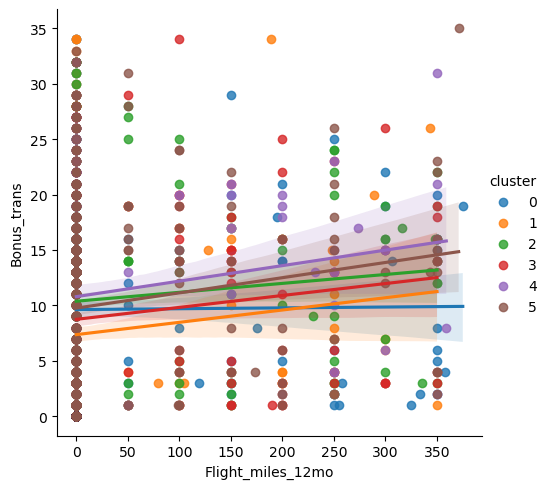

In [23]:
sns.lmplot(data=features,x='Flight_miles_12mo',y='Bonus_trans',hue='cluster')

In [24]:
cluster.cluster_centers_

array([[0.00000000e+00, 1.92339545e+00, 1.00000000e+00, 1.00000000e+00,
        9.63975155e+00, 2.30828157e+01, 3.65620704e+03, 2.98136646e-01],
       [0.00000000e+00, 1.40684411e+00, 1.00000000e+00, 1.00000000e+00,
        7.50000000e+00, 1.24144487e+01, 1.22416350e+03, 1.31178707e-01],
       [0.00000000e+00, 2.24572650e+00, 1.00000000e+00, 1.00000000e+00,
        1.05683761e+01, 2.28183761e+01, 6.11716667e+03, 3.56837607e-01],
       [0.00000000e+00, 1.84512428e+00, 1.00000000e+00, 1.00000000e+00,
        8.93881453e+00, 1.81453155e+01, 2.42779350e+03, 2.90630975e-01],
       [0.00000000e+00, 2.26022305e+00, 1.00000000e+00, 1.00000000e+00,
        1.10929368e+01, 2.16133829e+01, 7.53697026e+03, 3.68029740e-01],
       [0.00000000e+00, 2.07287449e+00, 1.00000000e+00, 1.00000000e+00,
        1.00283401e+01, 2.02145749e+01, 4.83741093e+03, 3.23886640e-01]])

In [25]:
print("Silhoutte Score is :",silhouette_score(features,cluster.labels_))
print("Davis Bouldin Score is :",davies_bouldin_score(features,cluster.labels_))

Silhoutte Score is : 0.5186596769969168
Davis Bouldin Score is : 0.5544176045601874


In [26]:
kmeans.inertia_

452384509.9747701

#### Using Elbow Method

In [27]:
inertia=[]
for i in range(1,11):
    kmeans=KMeans(n_clusters=i,init='k-means++', random_state=42)
    kmeans.fit(features)
    inertia.append(kmeans.inertia_)

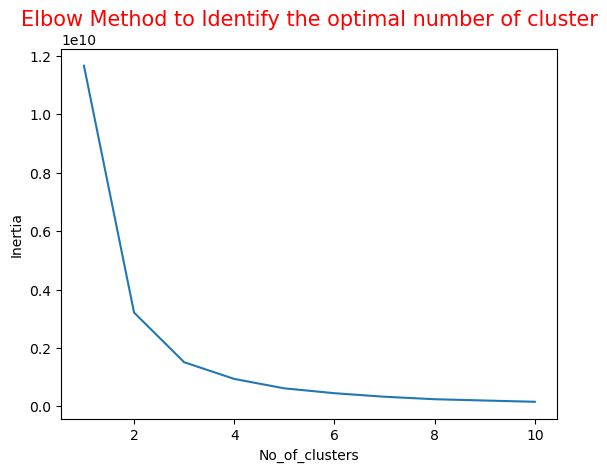

In [28]:
plt.plot(range(1,11),inertia)
plt.xlabel('No_of_clusters')
plt.ylabel('Inertia');
plt.title('Elbow Method to Identify the optimal number of cluster',color='red',size=15);

Looking at the lineplot we can say that the most optimum number of clusters for this dataset is 4 since after that the data loss is not exponential.

In [29]:
kmeans=KMeans(n_clusters=3,random_state=42)
cluster= kmeans.fit(features)
cluster.labels_

array([2, 2, 2, ..., 1, 1, 1])

In [30]:
print("Silhoutte Score is :",silhouette_score(features,cluster.labels_))
print("Davis Bouldin Score is :",davies_bouldin_score(features,cluster.labels_))

Silhoutte Score is : 0.5735136625343834
Davis Bouldin Score is : 0.5208801999274764


By looking at the new silhoutee_score we can say that the model performance has been improved.

#### DBSCAN Algorithm

In [31]:
x= df.iloc[:].values
x.shape

(2763, 9)

In [32]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=130, min_samples = 4, metric="euclidean")
db.fit(x)

DBSCAN(eps=130, min_samples=4)

In [33]:
label = db.labels_
label

array([-1, -1, -1, ..., -1, -1, -1], dtype=int64)

In [34]:
sample_cores=np.zeros_like(label,dtype=bool)
sample_cores[db.core_sample_indices_]=True

In [35]:
n_clusters=len(set(label))-(1 if -1 in label else 0)
print('No of clusters:',n_clusters)

No of clusters: 9


In [36]:
y_means = db.fit_predict(x)
y_means

array([-1, -1, -1, ..., -1, -1, -1], dtype=int64)

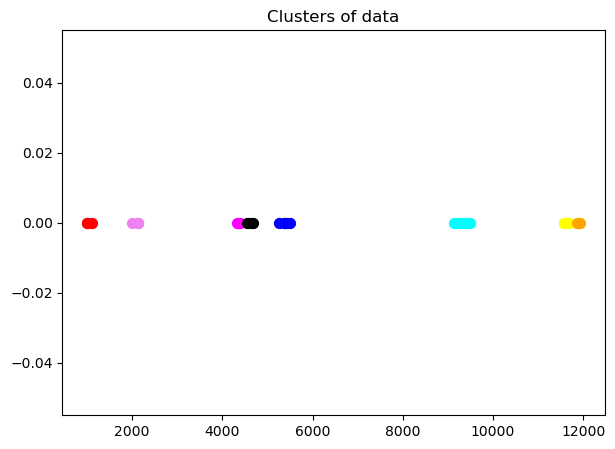

In [37]:
plt.figure(figsize=(7,5))
plt.scatter(x[y_means == 0, 0], x[y_means == 0, 1], s = 50, c = 'pink')
plt.scatter(x[y_means == 1, 0], x[y_means == 1, 1], s = 50, c = 'yellow')
plt.scatter(x[y_means == 2, 0], x[y_means == 2, 1], s = 50, c = 'cyan')
plt.scatter(x[y_means == 3, 0], x[y_means == 3, 1], s = 50, c = 'magenta')
plt.scatter(x[y_means == 4, 0], x[y_means == 4, 1], s = 50, c = 'orange')
plt.scatter(x[y_means == 5, 0], x[y_means == 5, 1], s = 50, c = 'blue')
plt.scatter(x[y_means == 6, 0], x[y_means == 6, 1], s = 50, c = 'red')
plt.scatter(x[y_means == 7, 0], x[y_means == 7, 1], s = 50, c = 'black')
plt.scatter(x[y_means == 8, 0], x[y_means == 8, 1], s = 50, c = 'violet')
plt.title('Clusters of data')
plt.show()

In [38]:
#Finding silhouette score for DBSCAN Algorithm
from sklearn.metrics import silhouette_score

labels_db = db.labels_
sil_score = silhouette_score(x, labels_db)
print("Silhouette Score of DBSCAN Algorithm is : ", sil_score)
print("Davis Bouldin Score is :",davies_bouldin_score(x,labels_db))

Silhouette Score of DBSCAN Algorithm is :  -0.3038353841025521
Davis Bouldin Score is : 0.8376573686279081


We can see our Silhouette Score is quite low so we can say that our model is not able to generalize this dataset that well.
We can observe the same thing in the graph as well, few of the clusters are overlapping.

#### Implementing Hierarchical Clustering algorithm.

In [39]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

model = AgglomerativeClustering(n_clusters=3, linkage='complete')    #types of linkage are {'ward', 'complete', 'single', 'average'}
model.fit(x)

AgglomerativeClustering(linkage='complete', n_clusters=3)

In [40]:
y_means = model.fit_predict(x)
y_means

array([1, 1, 1, ..., 1, 0, 1], dtype=int64)

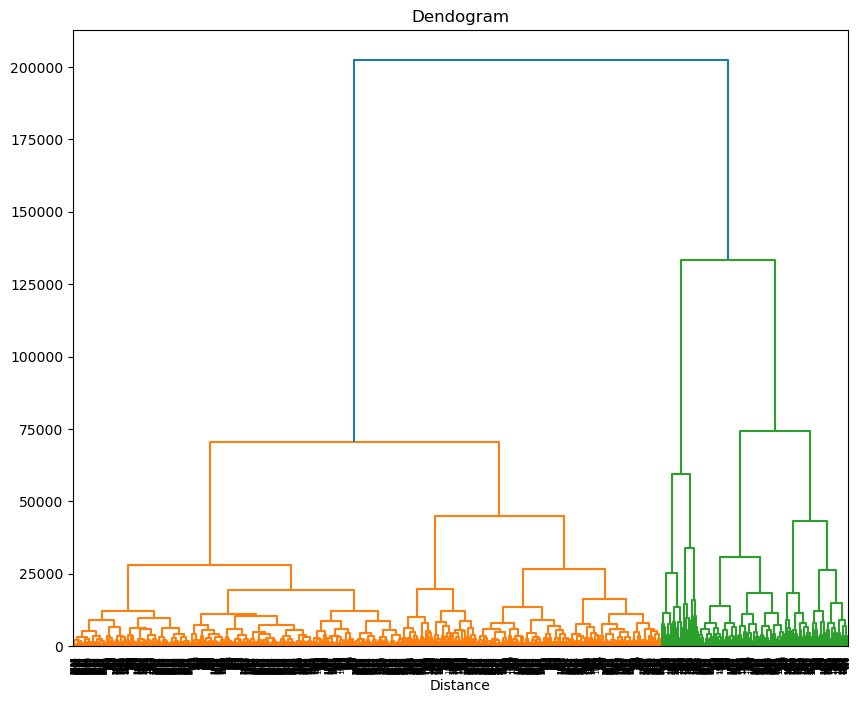

In [41]:
linked = linkage(x, method="complete")
plt.figure(figsize=(10,8))
dendrogram(linked)
plt.title("Dendogram")
plt.xlabel("Data points")
plt.xlabel("Distance")
plt.show()

In [42]:
from scipy.cluster.hierarchy import fcluster

max_distance = 10
clusters = fcluster(linked, max_distance, criterion='distance')
print("The clusters formed are : \n", clusters)

The clusters formed are : 
 [1560  986 1883 ... 1177 2272   60]


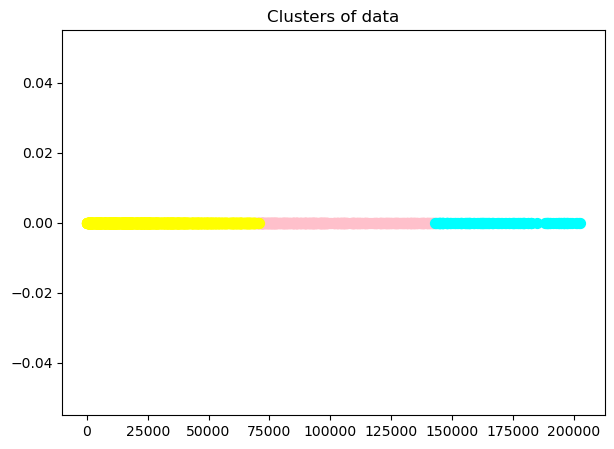

In [43]:
plt.figure(figsize=(7,5))
plt.scatter(x[y_means == 0, 0], x[y_means == 0, 1], s = 50, c = 'pink')
plt.scatter(x[y_means == 1, 0], x[y_means == 1, 1], s = 50, c = 'yellow')
plt.scatter(x[y_means == 2, 0], x[y_means == 2, 1], s = 50, c = 'cyan')
plt.title('Clusters of data')
plt.show()

In [44]:
#Finding silhouette score for DBSCAN Algorithm
from sklearn.metrics import silhouette_score

labels_hier = model.labels_
sil_score = silhouette_score(x, labels_hier)
print("Silhouette Score of DBSCAN Algorithm is : ", sil_score)
print("Davis Bouldin Score is :",davies_bouldin_score(x,labels_hier))

Silhouette Score of DBSCAN Algorithm is :  0.6255075769916975
Davis Bouldin Score is : 0.4885076984551124


* From above 3 Models the found stats are given as follows

KMeans :
* Number of clusters recommended by KMeans : 3
* Silhoutte Score is : 0.5735136625343834
* Davis Bouldin Score is : 0.5208801999274764

DBSCAN :
* Number of clusters recommended by DBSCAN : 9
* Silhouette Score of DBSCAN Algorithm is : -0.3038353841025521
* Davis Bouldin Score is : 0.8376573686279081

Hierarchical Clustering :
* Number of clusters recommended by hierarchical : 3
* Silhouette Score of hierarchical Algorithm is : 0.6255075769916975
* Davis Bouldin Score is : 0.4885076984551124


On comparing all the 3 models we can say that:
* DBSCAN is performing tierribly for this dataset.
* Hierarchical and KMeans are performing well comparatively.
* We can conclude that the number of clusters that should be formed is 3.